# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
!pip install --upgrade pip
!pip install torch
#!pip install torchvision
#!pip install -U numpy
#!pip show numpy

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.3.1)


In [3]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [4]:
# necessary imports
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
data_dir = 'processed_celeba_small/'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
                                    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [7]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

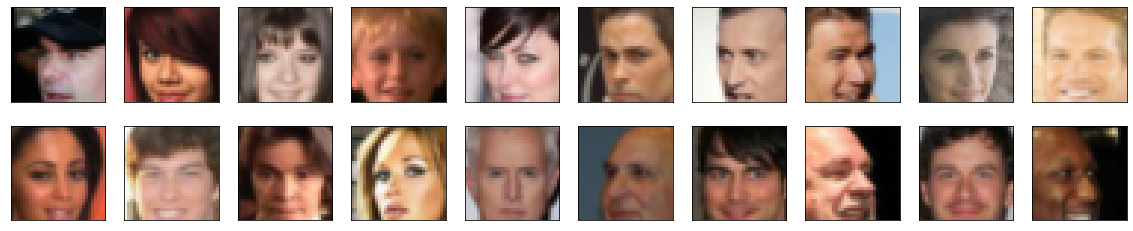

In [8]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
     # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
    

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.6863)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [11]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    
    elif hasattr(m, 'weight') and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
# params
#lr = 0.0002
lr = 0.001
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
def optimizer():
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

    return d_optimizer, g_optimizer

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
train_n = 1
param = 'num_epochs'

In [22]:
def save_data(index, losses):
    losses = np.array(losses)
    
    # Export Loss as Dataframe
    idx = range(len(losses.T[0]))
    d = {'Discriminator': losses.T[0], 'Generator': losses.T[1]}
    loss_df = pd.DataFrame(data=d, index = idx)
    train_number = train_n + index
    loss_df.to_excel('train_' + str(train_number) +'_'+ param + ".xlsx")
    
    # Export hyperparameters
    hyper_params = {'batch_size': batch_size,
                'img_size': img_size,
                'deconv-layers': 3,
                'conv-layers': 3,
                'd_conv_dim': d_conv_dim,
                'g_conv_dim': g_conv_dim,
                'z_size': z_size,
                'lr': lr,
                'beta1': beta1,
                'beta2': beta2,
                'dropout': 'no',
                'n_epochs': n_epochs
                }
    hyper_param_df = pd.DataFrame.from_dict(hyper_params, orient='index')
    hyper_param_df.to_excel('train_' + str(train_number) +'_'+ param + "_hyper_param.xlsx")
    print(hyper_params)

In [23]:
def plot_training_loss(losses):
    print('Plot Loss')
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(index, epoch=-1):
    print('View Samples')
    train_number = train_n + index
    # Load samples from generator, taken while training
    with open('train_' + str(train_number) +'_'+ param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [25]:
def train(D, G, index, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_number = train_n + index
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_' + str(train_number) +'_'+ param + '_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

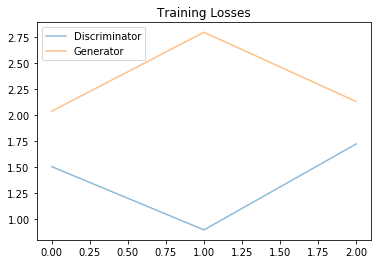

View Samples


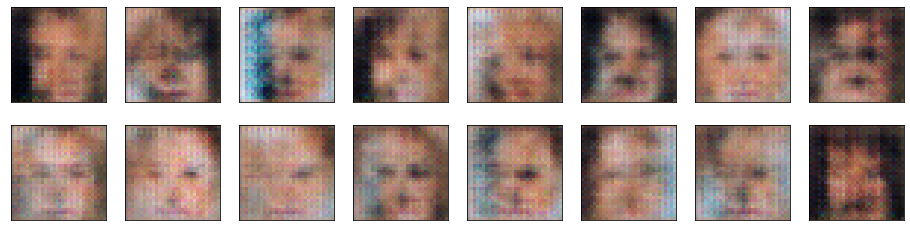

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

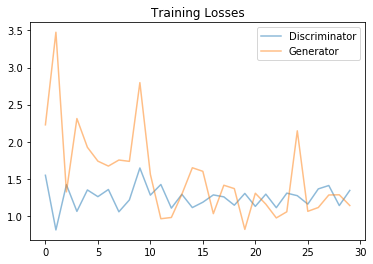

View Samples


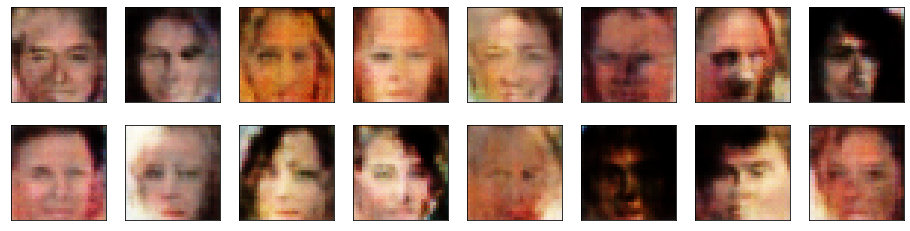

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

Epoch [   44/   50] | d_loss: 1.0365 | g_loss: 1.1397
Epoch [   44/   50] | d_loss: 0.8629 | g_loss: 1.8134
Epoch [   44/   50] | d_loss: 1.0591 | g_loss: 1.5491
Epoch [   45/   50] | d_loss: 0.7713 | g_loss: 1.6613
Epoch [   45/   50] | d_loss: 0.7457 | g_loss: 2.0836
Epoch [   45/   50] | d_loss: 0.9579 | g_loss: 1.3443
Epoch [   46/   50] | d_loss: 0.8855 | g_loss: 1.8138
Epoch [   46/   50] | d_loss: 1.0410 | g_loss: 2.5382
Epoch [   46/   50] | d_loss: 0.9978 | g_loss: 0.8729
Epoch [   47/   50] | d_loss: 1.0182 | g_loss: 1.0990
Epoch [   47/   50] | d_loss: 0.8561 | g_loss: 2.1411
Epoch [   47/   50] | d_loss: 0.7207 | g_loss: 1.6238
Epoch [   48/   50] | d_loss: 0.6662 | g_loss: 2.1102
Epoch [   48/   50] | d_loss: 0.9712 | g_loss: 2.3341
Epoch [   48/   50] | d_loss: 0.7645 | g_loss: 1.5669
Epoch [   49/   50] | d_loss: 0.8750 | g_loss: 1.1992
Epoch [   49/   50] | d_loss: 0.8417 | g_loss: 1.9832
Epoch [   49/   50] | d_loss: 0.7849 | g_loss: 2.2185
Epoch [   50/   50] | d_loss

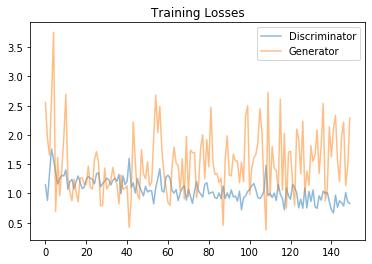

View Samples


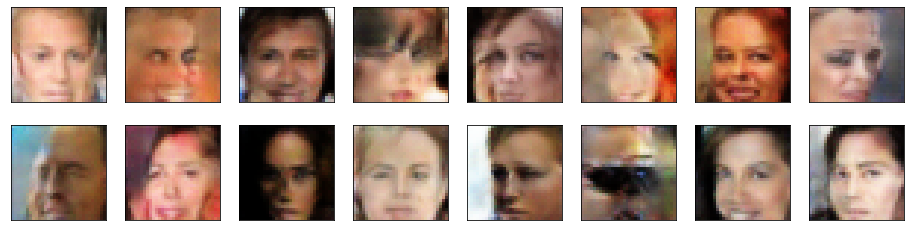

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

Epoch [   44/  100] | d_loss: 0.9174 | g_loss: 1.8695
Epoch [   44/  100] | d_loss: 0.9928 | g_loss: 1.3641
Epoch [   44/  100] | d_loss: 1.0699 | g_loss: 1.9805
Epoch [   45/  100] | d_loss: 0.9782 | g_loss: 2.4271
Epoch [   45/  100] | d_loss: 0.7568 | g_loss: 1.3415
Epoch [   45/  100] | d_loss: 0.9232 | g_loss: 1.4289
Epoch [   46/  100] | d_loss: 1.0708 | g_loss: 2.6146
Epoch [   46/  100] | d_loss: 0.9378 | g_loss: 1.9213
Epoch [   46/  100] | d_loss: 0.6921 | g_loss: 2.0010
Epoch [   47/  100] | d_loss: 0.7696 | g_loss: 1.8074
Epoch [   47/  100] | d_loss: 0.9484 | g_loss: 0.7552
Epoch [   47/  100] | d_loss: 1.0678 | g_loss: 1.0113
Epoch [   48/  100] | d_loss: 0.9704 | g_loss: 2.3332
Epoch [   48/  100] | d_loss: 1.2975 | g_loss: 0.8826
Epoch [   48/  100] | d_loss: 1.0851 | g_loss: 0.8570
Epoch [   49/  100] | d_loss: 0.8252 | g_loss: 1.4954
Epoch [   49/  100] | d_loss: 0.8324 | g_loss: 1.4693
Epoch [   49/  100] | d_loss: 1.0157 | g_loss: 1.6876
Epoch [   50/  100] | d_loss

Epoch [   94/  100] | d_loss: 0.3266 | g_loss: 3.4521
Epoch [   95/  100] | d_loss: 0.3010 | g_loss: 2.9916
Epoch [   95/  100] | d_loss: 0.3225 | g_loss: 3.4480
Epoch [   95/  100] | d_loss: 0.4061 | g_loss: 2.5715
Epoch [   96/  100] | d_loss: 0.2434 | g_loss: 3.4661
Epoch [   96/  100] | d_loss: 1.0335 | g_loss: 0.5985
Epoch [   96/  100] | d_loss: 0.4649 | g_loss: 2.1150
Epoch [   97/  100] | d_loss: 0.3396 | g_loss: 2.2647
Epoch [   97/  100] | d_loss: 0.2710 | g_loss: 1.9948
Epoch [   97/  100] | d_loss: 0.5101 | g_loss: 3.1941
Epoch [   98/  100] | d_loss: 0.7695 | g_loss: 1.3851
Epoch [   98/  100] | d_loss: 0.3171 | g_loss: 3.0374
Epoch [   98/  100] | d_loss: 0.3799 | g_loss: 2.5459
Epoch [   99/  100] | d_loss: 0.4491 | g_loss: 3.1652
Epoch [   99/  100] | d_loss: 0.3401 | g_loss: 2.0425
Epoch [   99/  100] | d_loss: 0.4052 | g_loss: 3.7838
Epoch [  100/  100] | d_loss: 0.5066 | g_loss: 4.6513
Epoch [  100/  100] | d_loss: 0.3733 | g_loss: 3.4803
Epoch [  100/  100] | d_loss

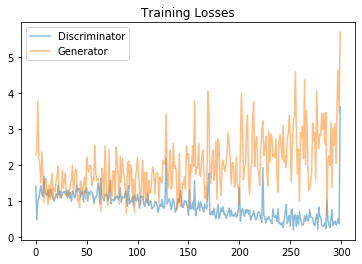

View Samples


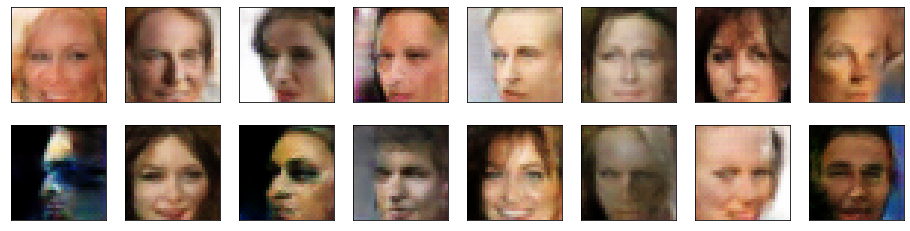

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

Epoch [   44/  500] | d_loss: 1.0911 | g_loss: 2.0434
Epoch [   44/  500] | d_loss: 1.0388 | g_loss: 1.8342
Epoch [   44/  500] | d_loss: 1.2469 | g_loss: 2.1894
Epoch [   45/  500] | d_loss: 0.6843 | g_loss: 1.8264
Epoch [   45/  500] | d_loss: 0.9477 | g_loss: 2.5141
Epoch [   45/  500] | d_loss: 0.8928 | g_loss: 2.3131
Epoch [   46/  500] | d_loss: 0.9784 | g_loss: 1.0542
Epoch [   46/  500] | d_loss: 0.7914 | g_loss: 1.7465
Epoch [   46/  500] | d_loss: 1.1070 | g_loss: 0.7357
Epoch [   47/  500] | d_loss: 0.7837 | g_loss: 2.2428
Epoch [   47/  500] | d_loss: 1.2677 | g_loss: 2.8920
Epoch [   47/  500] | d_loss: 0.8351 | g_loss: 1.7076
Epoch [   48/  500] | d_loss: 0.8617 | g_loss: 1.3239
Epoch [   48/  500] | d_loss: 1.2700 | g_loss: 2.6865
Epoch [   48/  500] | d_loss: 0.7997 | g_loss: 1.9366
Epoch [   49/  500] | d_loss: 1.2078 | g_loss: 0.7510
Epoch [   49/  500] | d_loss: 0.7304 | g_loss: 2.3472
Epoch [   49/  500] | d_loss: 0.6382 | g_loss: 1.7480
Epoch [   50/  500] | d_loss

Epoch [   94/  500] | d_loss: 0.3716 | g_loss: 2.7580
Epoch [   95/  500] | d_loss: 0.3430 | g_loss: 2.0487
Epoch [   95/  500] | d_loss: 0.4825 | g_loss: 3.5715
Epoch [   95/  500] | d_loss: 0.6087 | g_loss: 2.9922
Epoch [   96/  500] | d_loss: 0.6798 | g_loss: 3.3640
Epoch [   96/  500] | d_loss: 0.6000 | g_loss: 3.5291
Epoch [   96/  500] | d_loss: 0.6420 | g_loss: 2.1250
Epoch [   97/  500] | d_loss: 0.3365 | g_loss: 2.9186
Epoch [   97/  500] | d_loss: 1.2174 | g_loss: 0.3169
Epoch [   97/  500] | d_loss: 0.4166 | g_loss: 1.9083
Epoch [   98/  500] | d_loss: 0.6946 | g_loss: 3.1746
Epoch [   98/  500] | d_loss: 0.3007 | g_loss: 2.2495
Epoch [   98/  500] | d_loss: 0.3429 | g_loss: 2.4836
Epoch [   99/  500] | d_loss: 0.6504 | g_loss: 4.1912
Epoch [   99/  500] | d_loss: 0.3965 | g_loss: 3.3570
Epoch [   99/  500] | d_loss: 0.5327 | g_loss: 1.8970
Epoch [  100/  500] | d_loss: 0.4467 | g_loss: 1.6216
Epoch [  100/  500] | d_loss: 0.7617 | g_loss: 4.4708
Epoch [  100/  500] | d_loss

Epoch [  145/  500] | d_loss: 0.3832 | g_loss: 5.8375
Epoch [  145/  500] | d_loss: 1.8138 | g_loss: 5.2199
Epoch [  146/  500] | d_loss: 0.3149 | g_loss: 3.7760
Epoch [  146/  500] | d_loss: 0.1811 | g_loss: 4.2905
Epoch [  146/  500] | d_loss: 0.3243 | g_loss: 4.2423
Epoch [  147/  500] | d_loss: 0.1331 | g_loss: 4.0457
Epoch [  147/  500] | d_loss: 0.2460 | g_loss: 4.0374
Epoch [  147/  500] | d_loss: 4.7142 | g_loss: 4.6149
Epoch [  148/  500] | d_loss: 0.7653 | g_loss: 1.9845
Epoch [  148/  500] | d_loss: 0.3231 | g_loss: 2.9035
Epoch [  148/  500] | d_loss: 0.3026 | g_loss: 2.7160
Epoch [  149/  500] | d_loss: 0.2672 | g_loss: 4.8213
Epoch [  149/  500] | d_loss: 0.2475 | g_loss: 4.0402
Epoch [  149/  500] | d_loss: 0.2691 | g_loss: 3.8050
Epoch [  150/  500] | d_loss: 0.1450 | g_loss: 3.4889
Epoch [  150/  500] | d_loss: 0.2590 | g_loss: 2.9052
Epoch [  150/  500] | d_loss: 0.2916 | g_loss: 2.0582
Epoch [  151/  500] | d_loss: 1.2322 | g_loss: 0.3927
Epoch [  151/  500] | d_loss

Epoch [  196/  500] | d_loss: 0.2062 | g_loss: 4.9394
Epoch [  196/  500] | d_loss: 0.1859 | g_loss: 4.2781
Epoch [  196/  500] | d_loss: 0.3088 | g_loss: 3.5873
Epoch [  197/  500] | d_loss: 0.1263 | g_loss: 2.5791
Epoch [  197/  500] | d_loss: 0.2719 | g_loss: 3.7060
Epoch [  197/  500] | d_loss: 0.1396 | g_loss: 4.7446
Epoch [  198/  500] | d_loss: 0.2054 | g_loss: 4.8936
Epoch [  198/  500] | d_loss: 1.6034 | g_loss: 6.7245
Epoch [  198/  500] | d_loss: 0.1827 | g_loss: 4.3616
Epoch [  199/  500] | d_loss: 0.3029 | g_loss: 3.5844
Epoch [  199/  500] | d_loss: 0.1138 | g_loss: 3.7817
Epoch [  199/  500] | d_loss: 0.1596 | g_loss: 3.7198
Epoch [  200/  500] | d_loss: 0.0925 | g_loss: 5.0656
Epoch [  200/  500] | d_loss: 0.1707 | g_loss: 5.0286
Epoch [  200/  500] | d_loss: 0.2154 | g_loss: 5.2133
Epoch [  201/  500] | d_loss: 0.1612 | g_loss: 5.1611
Epoch [  201/  500] | d_loss: 0.1535 | g_loss: 4.0262
Epoch [  201/  500] | d_loss: 0.0892 | g_loss: 5.7821
Epoch [  202/  500] | d_loss

Epoch [  246/  500] | d_loss: 0.1384 | g_loss: 5.9388
Epoch [  247/  500] | d_loss: 0.1252 | g_loss: 6.0594
Epoch [  247/  500] | d_loss: 0.0846 | g_loss: 5.5965
Epoch [  247/  500] | d_loss: 0.2446 | g_loss: 3.7373
Epoch [  248/  500] | d_loss: 0.5048 | g_loss: 7.2538
Epoch [  248/  500] | d_loss: 1.6596 | g_loss: 0.0882
Epoch [  248/  500] | d_loss: 2.4198 | g_loss: 5.1446
Epoch [  249/  500] | d_loss: 0.8724 | g_loss: 2.3512
Epoch [  249/  500] | d_loss: 0.3148 | g_loss: 4.0529
Epoch [  249/  500] | d_loss: 0.2902 | g_loss: 3.1985
Epoch [  250/  500] | d_loss: 0.3129 | g_loss: 3.2513
Epoch [  250/  500] | d_loss: 0.1596 | g_loss: 6.0608
Epoch [  250/  500] | d_loss: 0.1523 | g_loss: 5.1466
Epoch [  251/  500] | d_loss: 0.0895 | g_loss: 5.2571
Epoch [  251/  500] | d_loss: 0.1056 | g_loss: 3.3679
Epoch [  251/  500] | d_loss: 0.2617 | g_loss: 4.7375
Epoch [  252/  500] | d_loss: 0.1143 | g_loss: 4.5061
Epoch [  252/  500] | d_loss: 0.0932 | g_loss: 5.4323
Epoch [  252/  500] | d_loss

Epoch [  297/  500] | d_loss: 0.0877 | g_loss: 6.0565
Epoch [  297/  500] | d_loss: 0.0755 | g_loss: 5.2636
Epoch [  298/  500] | d_loss: 0.0474 | g_loss: 4.6624
Epoch [  298/  500] | d_loss: 0.0853 | g_loss: 5.1029
Epoch [  298/  500] | d_loss: 0.0509 | g_loss: 5.7240
Epoch [  299/  500] | d_loss: 0.1983 | g_loss: 4.9023
Epoch [  299/  500] | d_loss: 2.6972 | g_loss: 1.0166
Epoch [  299/  500] | d_loss: 0.3323 | g_loss: 3.0331
Epoch [  300/  500] | d_loss: 0.2437 | g_loss: 3.3804
Epoch [  300/  500] | d_loss: 0.2136 | g_loss: 3.2129
Epoch [  300/  500] | d_loss: 0.1302 | g_loss: 5.4044
Epoch [  301/  500] | d_loss: 0.2111 | g_loss: 4.3477
Epoch [  301/  500] | d_loss: 0.2236 | g_loss: 6.6529
Epoch [  301/  500] | d_loss: 0.2854 | g_loss: 5.4132
Epoch [  302/  500] | d_loss: 0.1522 | g_loss: 4.5568
Epoch [  302/  500] | d_loss: 0.0961 | g_loss: 5.3380
Epoch [  302/  500] | d_loss: 0.1786 | g_loss: 5.4707
Epoch [  303/  500] | d_loss: 0.1506 | g_loss: 5.3795
Epoch [  303/  500] | d_loss

Epoch [  348/  500] | d_loss: 0.0399 | g_loss: 6.0904
Epoch [  348/  500] | d_loss: 0.2082 | g_loss: 5.0761
Epoch [  348/  500] | d_loss: 0.0725 | g_loss: 5.8666
Epoch [  349/  500] | d_loss: 0.2402 | g_loss: 6.2706
Epoch [  349/  500] | d_loss: 0.0701 | g_loss: 5.0739
Epoch [  349/  500] | d_loss: 0.0679 | g_loss: 5.3240
Epoch [  350/  500] | d_loss: 0.1703 | g_loss: 5.9951
Epoch [  350/  500] | d_loss: 0.1431 | g_loss: 4.9234
Epoch [  350/  500] | d_loss: 0.1983 | g_loss: 5.2700
Epoch [  351/  500] | d_loss: 0.0900 | g_loss: 4.3373
Epoch [  351/  500] | d_loss: 1.4758 | g_loss: 5.9449
Epoch [  351/  500] | d_loss: 0.1531 | g_loss: 5.2825
Epoch [  352/  500] | d_loss: 0.1117 | g_loss: 6.7217
Epoch [  352/  500] | d_loss: 0.1350 | g_loss: 5.1090
Epoch [  352/  500] | d_loss: 0.1040 | g_loss: 4.7368
Epoch [  353/  500] | d_loss: 0.1115 | g_loss: 4.0943
Epoch [  353/  500] | d_loss: 0.0895 | g_loss: 5.7862
Epoch [  353/  500] | d_loss: 0.2237 | g_loss: 4.7746
Epoch [  354/  500] | d_loss

Epoch [  398/  500] | d_loss: 0.1686 | g_loss: 4.4982
Epoch [  399/  500] | d_loss: 0.8442 | g_loss: 1.3512
Epoch [  399/  500] | d_loss: 0.2072 | g_loss: 6.5873
Epoch [  399/  500] | d_loss: 0.1104 | g_loss: 6.0630
Epoch [  400/  500] | d_loss: 0.0806 | g_loss: 6.6499
Epoch [  400/  500] | d_loss: 0.0685 | g_loss: 4.3420
Epoch [  400/  500] | d_loss: 0.0969 | g_loss: 4.5134
Epoch [  401/  500] | d_loss: 0.1551 | g_loss: 5.2625
Epoch [  401/  500] | d_loss: 0.7381 | g_loss: 4.2391
Epoch [  401/  500] | d_loss: 0.0897 | g_loss: 6.3046
Epoch [  402/  500] | d_loss: 0.1965 | g_loss: 5.1294
Epoch [  402/  500] | d_loss: 0.0828 | g_loss: 5.9569
Epoch [  402/  500] | d_loss: 0.2841 | g_loss: 5.2215
Epoch [  403/  500] | d_loss: 0.0875 | g_loss: 6.0080
Epoch [  403/  500] | d_loss: 0.1055 | g_loss: 5.6010
Epoch [  403/  500] | d_loss: 0.0412 | g_loss: 4.6170
Epoch [  404/  500] | d_loss: 0.1117 | g_loss: 5.7864
Epoch [  404/  500] | d_loss: 0.0471 | g_loss: 5.7919
Epoch [  404/  500] | d_loss

Epoch [  449/  500] | d_loss: 0.5261 | g_loss: 1.7981
Epoch [  449/  500] | d_loss: 0.2019 | g_loss: 3.6372
Epoch [  450/  500] | d_loss: 0.2206 | g_loss: 5.4095
Epoch [  450/  500] | d_loss: 0.0492 | g_loss: 6.8113
Epoch [  450/  500] | d_loss: 0.4413 | g_loss: 2.5302
Epoch [  451/  500] | d_loss: 0.0625 | g_loss: 6.3133
Epoch [  451/  500] | d_loss: 0.2055 | g_loss: 6.1564
Epoch [  451/  500] | d_loss: 0.0469 | g_loss: 4.7482
Epoch [  452/  500] | d_loss: 0.1419 | g_loss: 4.8198
Epoch [  452/  500] | d_loss: 0.0531 | g_loss: 4.9018
Epoch [  452/  500] | d_loss: 0.1079 | g_loss: 6.0652
Epoch [  453/  500] | d_loss: 0.0550 | g_loss: 6.0257
Epoch [  453/  500] | d_loss: 0.1267 | g_loss: 5.5271
Epoch [  453/  500] | d_loss: 0.1026 | g_loss: 6.2145
Epoch [  454/  500] | d_loss: 0.0675 | g_loss: 6.3586
Epoch [  454/  500] | d_loss: 0.0449 | g_loss: 6.5977
Epoch [  454/  500] | d_loss: 0.0858 | g_loss: 5.6683
Epoch [  455/  500] | d_loss: 0.0435 | g_loss: 7.4731
Epoch [  455/  500] | d_loss

Epoch [  500/  500] | d_loss: 0.0459 | g_loss: 8.1051
Epoch [  500/  500] | d_loss: 0.0130 | g_loss: 8.9629
Epoch [  500/  500] | d_loss: 0.0599 | g_loss: 11.0657
{'batch_size': 128, 'img_size': 32, 'deconv-layers': 3, 'conv-layers': 3, 'd_conv_dim': 32, 'g_conv_dim': 32, 'z_size': 100, 'lr': 0.001, 'beta1': 0.5, 'beta2': 0.999, 'dropout': 'no', 'n_epochs': 500}
Plot Loss


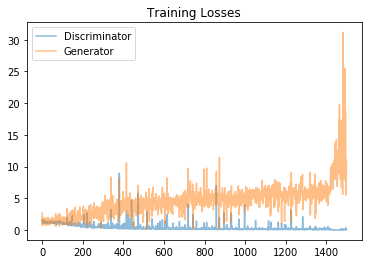

View Samples


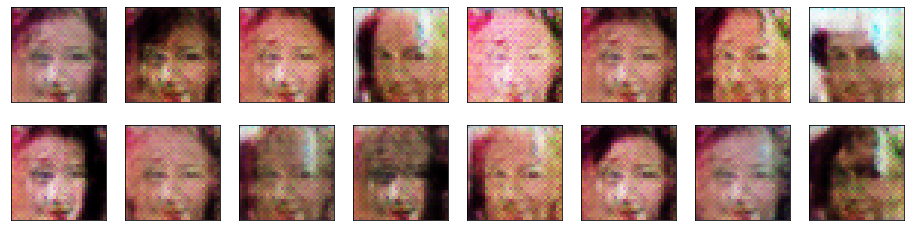

In [26]:
# set number of epochs 
number_epochs = [1, 10, 50, 100, 500]

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
for index, num_epochs in enumerate(number_epochs):
    # Set Parameter
    n_epochs = num_epochs
    
    # Build network
    print('Build Network')
    D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
    # Reset optimizer
    d_optimizer, g_optimizer = optimizer()
    
    # Calculate losses
    losses = train(D, G, index, n_epochs=n_epochs)
    
    # Save and Plot Data
    save_data(index, losses)
    plot_training_loss(losses)
    _ = view_samples(index, epoch=-1)
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

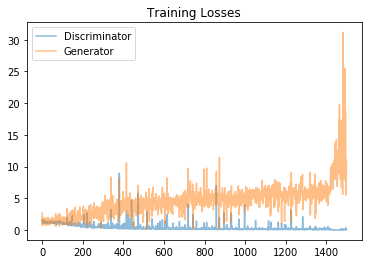

In [27]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [28]:
# helper function for viewing a list of passed in sample images
def view_samples_2(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [29]:
# Load samples from generator, taken while training
with open('train_1_num_epochs_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

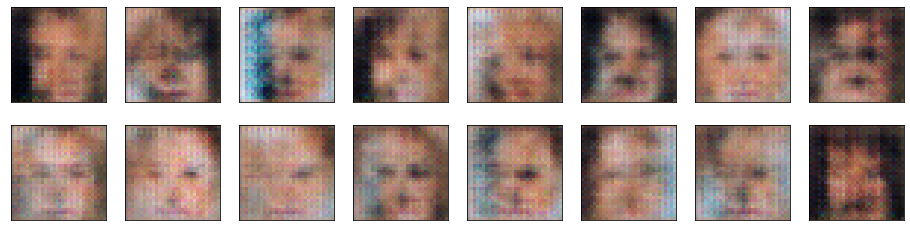

In [30]:
_ = view_samples_2(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.